In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Tue Jan 24 21:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    29W /  70W |   3311MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import libraries

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs





In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/NN_dataset_HW6/Dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.00025

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Load Data





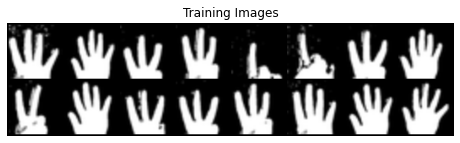

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## DCGAN model Implementation

### Weight Initialization


```
# This is formatted as code
```



In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Define Generator

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Define Discriminator


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions and Optimizers

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
noise_label = 0.85

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training


*   Step 1 - Train the Discriminator
*   Step 2 - Train the Generator


In [ ]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Training Loop
from torchmetrics.classification import BinaryAccuracy
metric = BinaryAccuracy().to(device)
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_accuracies = []
D_accuracies = []
iters = 0
G_loss_avg_list = []
D_loss_avg_list = []
G_acc_avg_list = []
D_acc_avg_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate D's accuracy on all-fake batch
        preds_real = output > 0.5
        accD_real = metric(preds_real,label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate D's accuracy on all-fake batch
        preds_fake = output > 0.5
        accD_fake = metric(preds_fake,label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Compute acc for D
        accD = (accD_real + accD_fake) * 0.5

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate D's accuracy on all-fake batch
        preds_G = output > 0.5
        accG = metric(preds_G,label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Save Accuracy for plotthing later
        G_accuracies.append(accG.item())
        D_accuracies.append(accD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        '''
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        '''
            
        iters += 1
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    G_avg = sum(G_losses) / len(G_losses)
    G_loss_avg_list.append(G_avg)
    D_avg = sum(D_losses) / len(D_losses)
    D_loss_avg_list.append(D_avg)

    G_avg2 = sum(G_accuracies) / len(G_accuracies)
    G_acc_avg_list.append(G_avg2)
    D_avg2 = sum(D_accuracies) / len(D_accuracies)
    D_acc_avg_list.append(D_avg2)

Starting Training Loop...
[0/50][0/63]	Loss_D: 2.8433	Loss_G: 5.1474	D(x): 0.2757	D(G(z)): 0.6028 / 0.0071
[0/50][20/63]	Loss_D: 0.1915	Loss_G: 15.6714	D(x): 0.8494	D(G(z)): 0.0000 / 0.0000
[0/50][40/63]	Loss_D: 0.0013	Loss_G: 13.8414	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000
[0/50][60/63]	Loss_D: 5.5226	Loss_G: 16.6197	D(x): 0.0307	D(G(z)): 0.0000 / 0.0000
[1/50][0/63]	Loss_D: 2.6420	Loss_G: 13.4709	D(x): 0.4621	D(G(z)): 0.0000 / 0.0000
[1/50][20/63]	Loss_D: 0.0989	Loss_G: 6.3154	D(x): 0.9532	D(G(z)): 0.0414 / 0.0106
[1/50][40/63]	Loss_D: 0.1321	Loss_G: 10.8058	D(x): 0.8921	D(G(z)): 0.0005 / 0.0000
[1/50][60/63]	Loss_D: 0.1031	Loss_G: 8.2738	D(x): 0.9756	D(G(z)): 0.0711 / 0.0008
[2/50][0/63]	Loss_D: 0.0649	Loss_G: 6.9136	D(x): 0.9783	D(G(z)): 0.0393 / 0.0020
[2/50][20/63]	Loss_D: 0.0373	Loss_G: 7.5274	D(x): 0.9851	D(G(z)): 0.0214 / 0.0008
[2/50][40/63]	Loss_D: 0.3423	Loss_G: 5.3787	D(x): 0.8079	D(G(z)): 0.0075 / 0.0142
[2/50][60/63]	Loss_D: 0.0536	Loss_G: 3.8932	D(x): 0.9718	D(G(z)): 0.02

## Results

**Loss versus training iteration**


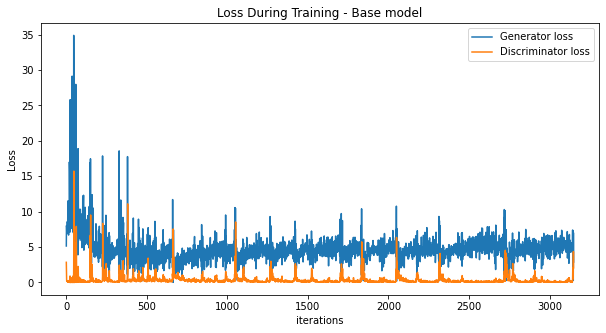

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Base model")
plt.plot(G_losses,label="Generator loss")
plt.plot(D_losses,label="Discriminator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_base_iteration.png')
plt.show()

**Loss versus training epochs**

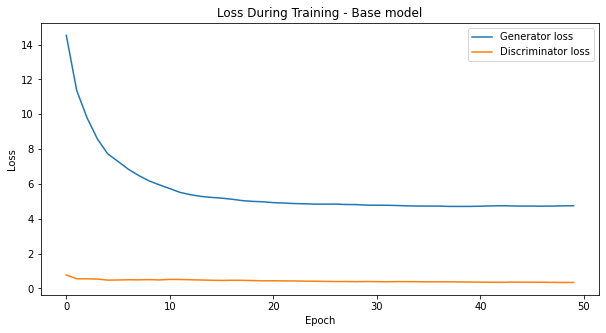

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Base model")
plt.plot(G_loss_avg_list,label="Generator loss")
plt.plot(D_loss_avg_list,label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_base_epoch.png')
plt.show()

**Accuracy versus training iterations**

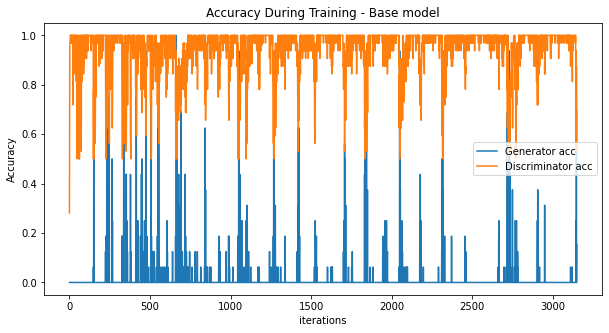

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Base model")
plt.plot(G_accuracies,label="Generator acc")
plt.plot(D_accuracies,label="Discriminator acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_base_iteration.png')
plt.show()

**Accuracy versus training epochs**

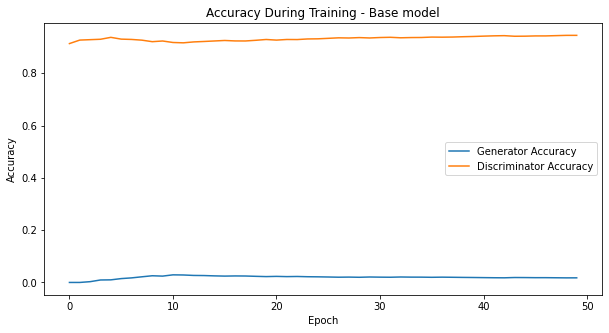

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Base model")
plt.plot(G_acc_avg_list,label="Generator Accuracy")
plt.plot(D_acc_avg_list,label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_base_epoch.png')
plt.show()

**Visualization of Generator’s progression**



In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

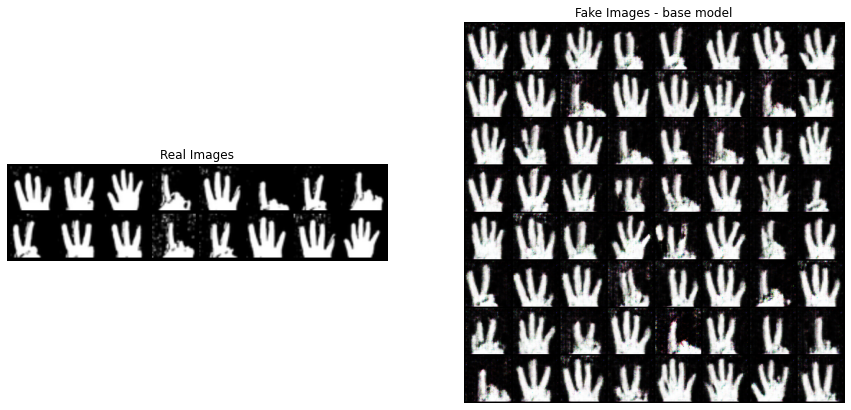

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images - base model")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Stable Model

*   Add noise
*   label smoothing



**Define model**

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# Create the Discriminator

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

**Fixed_noise and Optimizer**

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
noise_label = 0.85

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Train**

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_accuracies = []
D_accuracies = []
G_loss_avg_list = []
D_loss_avg_list = []
G_acc_avg_list = []
D_acc_avg_list = []
iters = 0
eps = 0.1
print("Starting Training Loop...")
# For each epoch
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
for epoch in range(num_epochs):
  
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        correct_real = 0
        correct_fake = 0
        correct_G = 0
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)             
        b_size = real_cpu.size(0)
        #print('b-size: ',b_size)
        noise_im = torch.randn(b_size, 3, 64, 64, device=device) * 0.1
        
        label = torch.full((b_size,), noise_label, dtype=torch.float, device=device)
        #print('noise:',noise_im.shape)
        #print('real: ',real_cpu.shape)
        real_noise = real_cpu + noise_im
        # Forward pass real batch through D
        output = netD(real_noise).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate accuracy on all_real batch
        preds_real = (output > 0.5).float() * 0.85
        correct_real += (preds_real == label).float().sum()
        accD_real = 100 * correct_real / len(label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate D's accuracy on all-fake batch
        preds_fake = (output > 0.5).float() * 0.85
        correct_fake += (preds_fake == label).float().sum()
        accD_fake = 100 * correct_fake / len(label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        accD = (accD_real + accD_fake) * 0.5
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(noise_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate G's accuracy on all-fake batch
        preds_G = (output > 0.5).float() * 0.85
        correct_G += (preds_G == label).float().sum()
        accG = 100 * correct_G / len(label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Save Accuracy for plotthing later
        G_accuracies.append(accG.item())
        D_accuracies.append(accD.item())
        iters += 1
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    G_avg = sum(G_losses) / len(G_losses)
    G_loss_avg_list.append(G_avg)
    D_avg = sum(D_losses) / len(D_losses)
    D_loss_avg_list.append(D_avg)

    G_avg2 = sum(G_accuracies) / len(G_accuracies)
    G_acc_avg_list.append(G_avg2)
    D_avg2 = sum(D_accuracies) / len(D_accuracies)
    D_acc_avg_list.append(D_avg2)

Starting Training Loop...
[0/50][0/63]	Loss_D: 1.2644	Loss_G: 4.2598	D(x): 0.4368	D(G(z)): 0.2471 / 0.0107
[0/50][20/63]	Loss_D: 0.6035	Loss_G: 6.8419	D(x): 0.9313	D(G(z)): 0.0313 / 0.0006
[0/50][40/63]	Loss_D: 0.7021	Loss_G: 5.7219	D(x): 0.9117	D(G(z)): 0.0677 / 0.0036
[0/50][60/63]	Loss_D: 0.8546	Loss_G: 4.7682	D(x): 0.9919	D(G(z)): 0.0593 / 0.0127
[1/50][0/63]	Loss_D: 0.6657	Loss_G: 3.4597	D(x): 0.8746	D(G(z)): 0.0570 / 0.0221
[1/50][20/63]	Loss_D: 0.5730	Loss_G: 4.6146	D(x): 0.9386	D(G(z)): 0.0522 / 0.0054
[1/50][40/63]	Loss_D: 0.6292	Loss_G: 1.7064	D(x): 0.6154	D(G(z)): 0.0316 / 0.1809
[1/50][60/63]	Loss_D: 0.5711	Loss_G: 4.2196	D(x): 0.6391	D(G(z)): 0.0069 / 0.0114
[2/50][0/63]	Loss_D: 0.7815	Loss_G: 3.9649	D(x): 0.5141	D(G(z)): 0.0043 / 0.0188
[2/50][20/63]	Loss_D: 0.5089	Loss_G: 3.6994	D(x): 0.7912	D(G(z)): 0.0381 / 0.0187
[2/50][40/63]	Loss_D: 0.5499	Loss_G: 6.9588	D(x): 0.9020	D(G(z)): 0.0141 / 0.0010
[2/50][60/63]	Loss_D: 0.5107	Loss_G: 4.4914	D(x): 0.8241	D(G(z)): 0.0468 / 

**Plot**

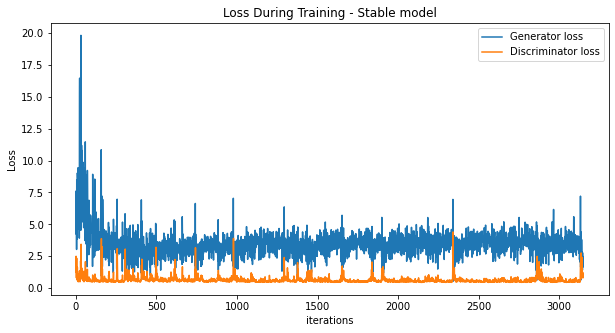

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Stable model")
plt.plot(G_losses,label="Generator loss")
plt.plot(D_losses,label="Discriminator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_Stable_iter.png')
plt.show()

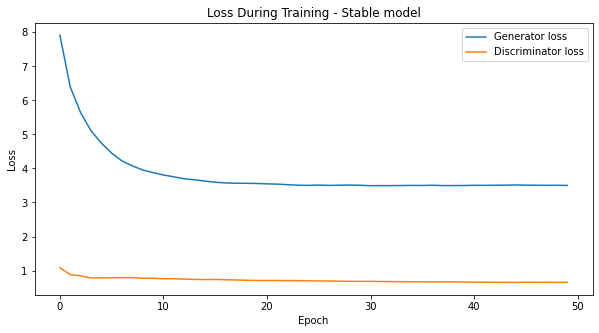

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Stable model")
plt.plot(G_loss_avg_list,label="Generator loss")
plt.plot(D_loss_avg_list,label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_Stable_epoch.png')
plt.show()

**Accuracy versus training iterations**

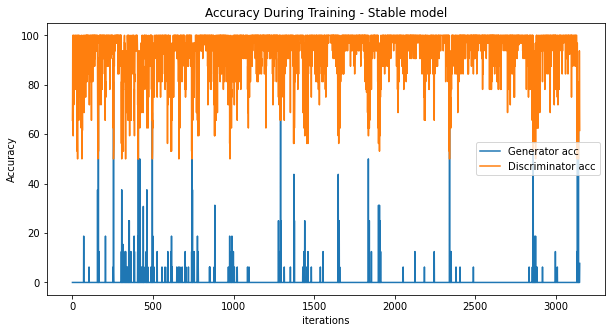

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Stable model")
plt.plot(G_accuracies,label="Generator acc")
plt.plot(D_accuracies,label="Discriminator acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_stable_iteration.png')
plt.show()

**Accuracy versus training epochs**

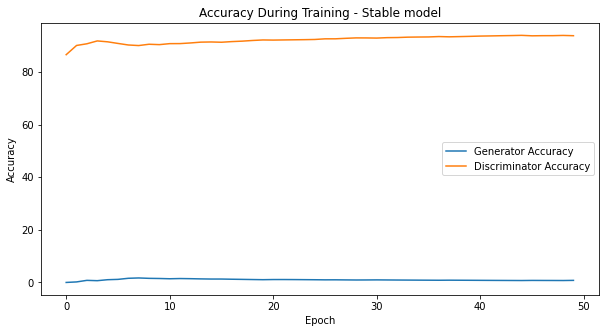

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Stable model")
plt.plot(G_acc_avg_list,label="Generator Accuracy")
plt.plot(D_acc_avg_list,label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_stable_epoch.png')
plt.show()

**Fake generated images after each epoch animation**

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real images vs Fake images(last epoch)**

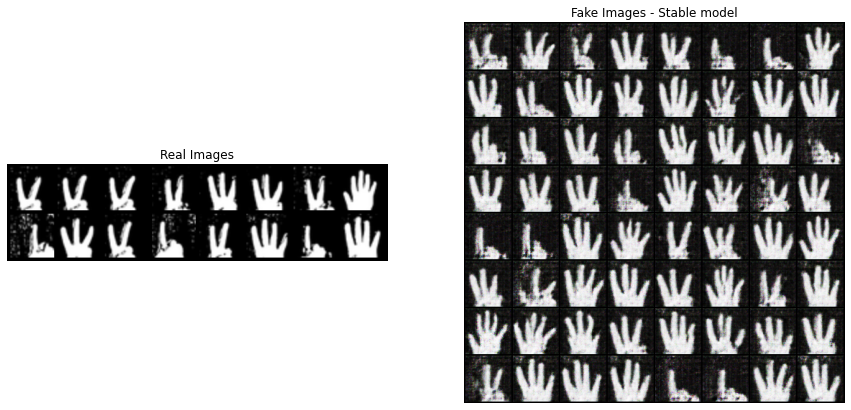

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images - Stable model")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
len(img_list)

51

## WGAN

**Define model**

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

In [ ]:
# Create the Discriminator

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

**Fixed noise and Optimizer**

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
noise_label = 0.85

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Train**

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_accuracies = []
D_accuracies = []
G_loss_avg_list = []
D_loss_avg_list = []
G_acc_avg_list = []
D_acc_avg_list = []
iters = 0
eps = 0.1
print("Starting Training Loop...")
# For each epoch
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
for epoch in range(num_epochs):
  
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        correct_real = 0
        correct_fake = 0
        correct_G = 0
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)             
        b_size = real_cpu.size(0)
        #print('b-size: ',b_size)
        noise_im = torch.randn(b_size, 3, 64, 64, device=device) * 0.1
        
        label = torch.full((b_size,), noise_label, dtype=torch.float, device=device)
        #print('noise:',noise_im.shape)
        #print('real: ',real_cpu.shape)
        real_noise = real_cpu + noise_im
        # Forward pass real batch through D
        output = netD(real_noise).view(-1)
        # Calculate loss on all-real batch
        #errD_real = criterion(output, label)
        erroD_real = -torch.mean(output)
        # Calculate accuracy on all_real batch
        preds_real = (output > 0.5).float() * 0.85
        correct_real += (preds_real == label).float().sum()
        accD_real = 100 * correct_real / len(label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        #errD_fake = criterion(output, label)
        errD_fake = torch.mean(output)
        # Calculate D's accuracy on all-fake batch
        preds_fake = (output > 0.5).float() * 0.85
        correct_fake += (preds_fake == label).float().sum()
        accD_fake = 100 * correct_fake / len(label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        accD = (accD_real + accD_fake) * 0.5
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(noise_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        #errG = criterion(output, label)
        errG = -torch.mean(output)
        # Calculate G's accuracy on all-fake batch
        preds_G = (output > 0.5).float() * 0.85
        correct_G += (preds_G == label).float().sum()
        accG = 100 * correct_G / len(label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Save Accuracy for plotthing later
        G_accuracies.append(accG.item())
        D_accuracies.append(accD.item())
        iters += 1
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    G_avg = sum(G_losses) / len(G_losses)
    G_loss_avg_list.append(G_avg)
    D_avg = sum(D_losses) / len(D_losses)
    D_loss_avg_list.append(D_avg)

    G_avg2 = sum(G_accuracies) / len(G_accuracies)
    G_acc_avg_list.append(G_avg2)
    D_avg2 = sum(D_accuracies) / len(D_accuracies)
    D_acc_avg_list.append(D_avg2)

**Plot loss**

**Loss versus training iterations**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - WGAN model")
plt.plot(G_losses,label="Generator loss")
plt.plot(D_losses,label="Discriminator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_WGAN_iter.png')
plt.show()

**Loss versus training epochs**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - WGAN model")
plt.plot(G_accuracies,label="Generator acc")
plt.plot(D_accuracies,label="Discriminator acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_WGAN_iteration.png')
plt.show()

**Accuracy versus training iterations**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - WGAN model")
plt.plot(G_acc_avg_list,label="Generator Accuracy")
plt.plot(D_acc_avg_list,label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_WGAN_epoch.png')
plt.show()

**Accuracy versus training epochs**

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - WGAN model")
plt.plot(G_acc_avg_list,label="Generator Accuracy")
plt.plot(D_acc_avg_list,label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_WGAN_epoch.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real images vs Fake images(last epoch)**

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images - WGAN model")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()